# Imports

In [1]:
# Freqtrade Workspace

# Notebook Helpers
%load_ext autoreload
%autoreload 2
%env WANDB_SILENT=true

# Standard Imports
from pathlib import Path
from typing import List, Callable, Tuple, Any
from wandb.wandb_run import Run
from datetime import datetime, timedelta

import attr
import gc
import os
import wandb
import nest_asyncio
import logging
import sys
import pandas as pd
import numpy as np
import qgrid

# Resolve CWD
gc.collect()
nest_asyncio.apply()

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.nbtools")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.INFO)

# Freqtrade Imports
from freqtrade.optimize.optimize_reports import text_table_add_metrics
from freqtrade.ml.lightning import LightningModule, LightningConfig
from freqtrade.ml.trainer import TradingTrainer
from freqtrade.ml.container import LightningContainer
from freqtrade.ml import loader, lightning_utils
from freqtrade.nbtools.preset import LocalPreset, ConfigPreset, FilePreset, CloudPreset
from freqtrade.nbtools.backtest import backtest, DataLoader
from freqtrade.nbtools import plotting, configs
from freqtrade.nbtools.helper import free_mem
from freqtrade.nbtools.pairs import PAIRS_HIGHCAP_NONSTABLE

# Constants
PATH_MOUNT = Path.cwd().parent / "mount"
PATH_DATA = PATH_MOUNT / "data"
PATH_PRESETS = PATH_MOUNT / "presets"
PATH_STRATEGIES = PATH_PRESETS / ".strategy_files"
DATALOADER = DataLoader(max_n_datasets=5)

# Define custom functions
def foo() -> str:
    return "bar"

env: WANDB_SILENT=true
freqtrade.nbtools.backtest - Initialized DataLoader with 5 max datas.


In [5]:
""" 
Strategy Backtesting Principles:

- In this case, we use "Long only" strategy.

- ZOOM OUT: Test in various market conditions, such as:
   > Bear Period - Profits should slight loss or ranging.
   > Bull Period - Profits must up!
   > Ranging Period - Profits should at least ranging. Up profits are welcome.

- ZOOM IN: Current condition validation: 
   > Test strategy to last 1 month data, determine if it's suitable to dry run.
"""
# List of available file strategies
strats = [it.name.replace(".py", "") for it in PATH_STRATEGIES.glob("*.py")]
paths = [str(it) for it in PATH_STRATEGIES.glob("*.py")]
df_strats = pd.DataFrame({"name": strats, "path": paths})
qgrid.show_grid(df_strats)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

# Strategy File Backtesting

Preset name: DIY_SuperDEMA
freqtrade.nbtools.preset.base_preset - Setting config for DIY_SuperDEMA ...
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 1 pairs)
freqtrade.nbtools.preset.base_preset - Add strategy search path C:\CS\Python\crypto-collection\freqtrade\mount\presets\.strategy_files
freqtrade.nbtools.preset.base_preset - Setting arg `datadir` to C:\CS\Python\crypto-collection\freqtrade\mount\data\binance
freqtrade.nbtools.preset.base_preset - Setting arg `timerange` to 20210501-
freqtrade.nbtools.backtest - Backtesting...
freqtrade.nbtools.backtest - Strategy using minimal_roi: {'0': 99}
freqtrade.nbtools.backtest - Strategy using timeframe: 15m
freqtrade.nbtools.backtest - Strategy using stoploss: -0.99
freqtrade.nbtools.backtest - Strategy using trailing_stop: False
freqtrade.nbtools.backtest - Strategy using trailing_stop_positive: 0.02
freqtrade.nbtools.backtest - Strategy using trailing_stop_positive_offset: 0.04
freqtrade.nbtools.backtest - Strategy

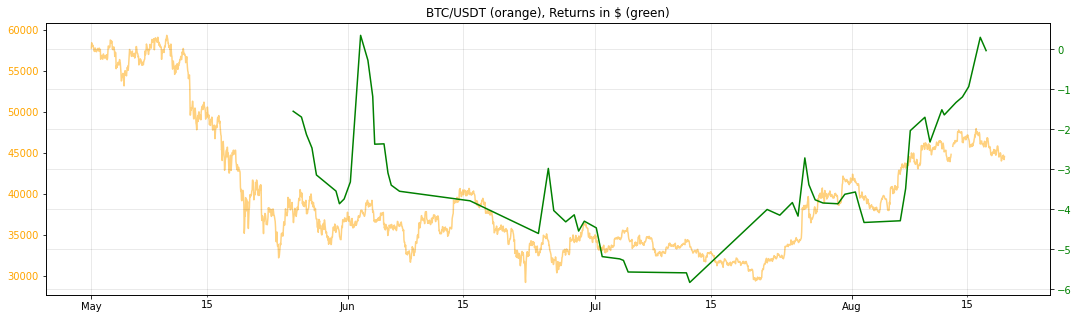

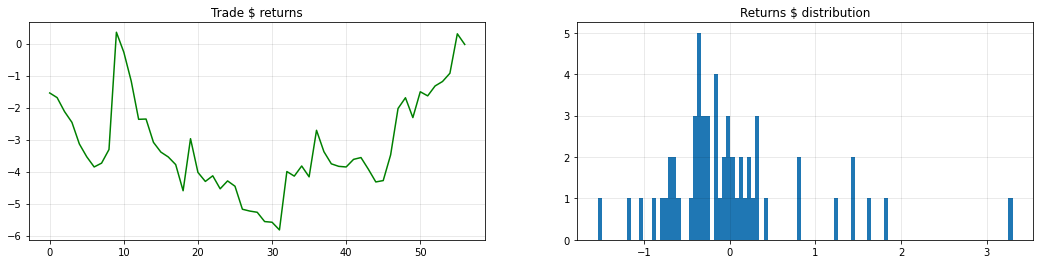

,Portfolio Summary
Min Balance,-5.82
Max Balance,0.35
End Balance,-0.03
Trades,57.00
Avg. Profit %,-0.00
Avg. Profit $,-0.00
Biggest Profit $,3.66
Biggest Loss $,-1.54


Exception ignored in: <function Exchange.__del__ at 0x000001C5423CDB80>
Traceback (most recent call last):
  File "C:\CS\Python\crypto-collection\freqtrade\superft\freqtrade\exchange\exchange.py", line 163, in __del__
    self.close()
  File "C:\CS\Python\crypto-collection\freqtrade\superft\freqtrade\exchange\exchange.py", line 168, in close
    asyncio.get_event_loop().run_until_complete(self._api_async.close())
  File "C:\Python\Python39\lib\asyncio\events.py", line 642, in get_event_loop
    raise RuntimeError('There is no current event loop in thread %r.'
RuntimeError: There is no current event loop in thread 'Thread-348'.


freqtrade.nbtools.backtest - ===============================
freqtrade.nbtools.backtest - |  'DIY_SuperDEMA__backtest-2021-08-20_17-09-19'
freqtrade.nbtools.backtest - |  WANDB LOG PRESET FINISHED  
freqtrade.nbtools.backtest - ===============================


In [12]:
strategy_classname = "DIY_SuperDEMA"  # Strategy Filename and Classname must same! 
timerange          = "20210501-"
pairs              = PAIRS_HIGHCAP_NONSTABLE
pairs              = [
    "DOGE/USDT",
# #     "BTC/USDT", "ETH/USDT", "ADA/USDT", "XRP/USDT", "BCH/USDT", "EOS/USDT", "NEO/USDT", "NANO/USDT", "XMR/USDT", "ZEC/USDT",
]

preset = FilePreset(
    timerange = timerange,
    config_dict = configs.DEFAULT_BUYMARKET,
    path_to_file = PATH_STRATEGIES / f"{strategy_classname}.py",
    path_data = PATH_DATA,
)

# Optional override
preset.overwrite_config(
    strategy_search_path = PATH_STRATEGIES,
    pairs                = pairs,
#     max_open_trades      = 3,
#     starting_balance     = 100,
#     stake_amount         = "unlimited",
#     timeframe            = "8h", # 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 8h, 12h, 1d, 3d, 1w
)

stats, summary = backtest(preset, preset.default_strategy_code, clsname=strategy_classname, dataloader=DATALOADER)
trades = pd.DataFrame(stats["strategy"][strategy_classname]["trades"])

plotting.plot_profits_timerange(
    trades,
    timerange,
    path_mount = PATH_MOUNT,
    name = preset.name
)

# Plot Profits

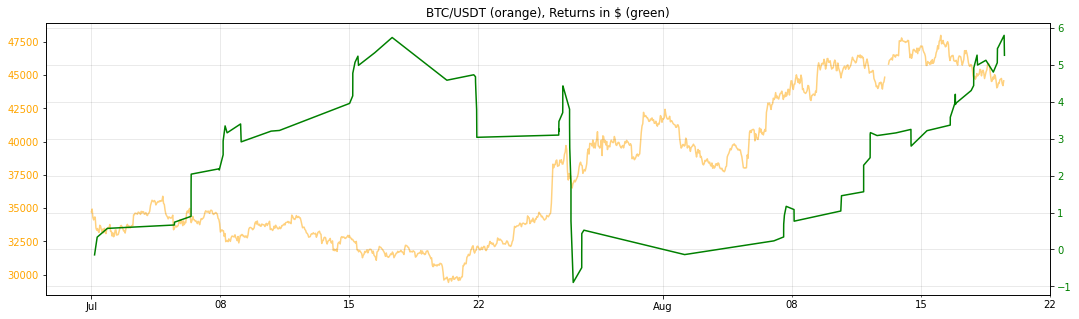

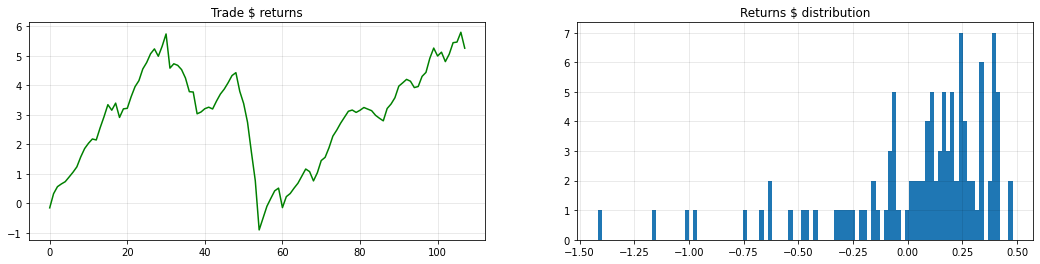

,Portfolio Summary
Min Balance,-0.90
Max Balance,5.80
End Balance,5.26
Trades,108.00
Avg. Profit %,0.32
Avg. Profit $,0.05
Biggest Profit $,0.48
Biggest Loss $,-1.67


freqtrade.nbtools.backtest - ===============================
freqtrade.nbtools.backtest - |  'NotAnotherSMAOffsetStrategy__backtest-2021-08-20_15-46-13'
freqtrade.nbtools.backtest - |  WANDB LOG PRESET FINISHED  
freqtrade.nbtools.backtest - ===============================


In [10]:
plotting.plot_profits(
    trades,
    start = "2021-07-01",
    end = "2021-09-01",
    path_mount = PATH_MOUNT,
    name = preset.name,
)

# Statistics

In [ ]:
def process_result_dataframe(result_df):
    result_df = result_df.drop(columns=["profit_mean", "profit_total", "profit_sum"])
    result_df = result_df.sort_values(by=["profit_total_abs"], ascending=False)
    result_df = result_df.round(2)
    return result_df

# Running this cell will print backtest results
results = deepcopy(stats["strategy"][strategy_classname])

# Results per pair
results_per_pair = pd.DataFrame(results["results_per_pair"]).set_index("key")
results_per_pair = process_result_dataframe(results_per_pair)

# Sell reason stats
sells = pd.DataFrame(results['sell_reason_summary']).set_index("sell_reason")
sells = process_result_dataframe(sells)

# Left open trades
left_open_trades = pd.DataFrame(results['left_open_trades']).set_index("key")
left_open_trades = process_result_dataframe(left_open_trades)

# Summary metrics
metrics = text_table_add_metrics(results)
advanced_metrics = deepcopy(stats["metadata"])
advanced_metrics["profit_mean"] = advanced_metrics["profit_mean"] * 100
advanced_metrics["profit_median"] = advanced_metrics["profit_median"] * 100
advanced_metrics["profit_total"] = advanced_metrics["profit_total"] * 100

for key in list(advanced_metrics):
    value = advanced_metrics[key]
    valid = any(isinstance(value, it) for it in [str, int, float, bool])
    
    if not valid:
        del advanced_metrics[key]
        continue
    
    if isinstance(value, float):
        advanced_metrics[key] =  round(value, 3)
    
    advanced_metrics[key] = [advanced_metrics[key]]
    
advanced_metrics_df = pd.DataFrame(advanced_metrics)
    
print("Results Per Pair")
display(results_per_pair)
print("Sell Reasons")
display(sells)
print("Left Open Trades")
display(left_open_trades)
print("Freqtrade Summary Metrics")
print("=" * 48 + "\n" + metrics + "\n" + "=" * 48)
print("Advanced Metrics")
print("Preset Name:", advanced_metrics_df["preset_name"][0])
display(advanced_metrics_df.drop(columns=["preset_name"]).T)# Running this cell will print backtest results
results = stats["strategy"]["NotebookStrategy"]

# Results per pair
results_per_pair = pd.DataFrame(results["results_per_pair"])
results_per_pair_df = results_per_pair.set_index("key").drop(columns=["profit_mean", "profit_total"])
results_per_pair_df = results_per_pair_df.sort_values(by=["profit_total_pct"], ascending=False)
results_per_pair_df.round(2)

# Sell reason stats
sells = pd.DataFrame(results['sell_reason_summary'])
sells = sells.drop(columns=["profit_mean", "profit_total"]).set_index("sell_reason")

# Left open trades
left_open_trades = pd.DataFrame(results['left_open_trades'])
left_open_trades = left_open_trades.drop(columns=["profit_mean", "profit_total"]).set_index("key")

# Summary metrics
metrics = text_table_add_metrics(results)

print("Results Per Pair")
display(results_per_pair_df.round(2))
print("Sell Reasons")
display(sells.round(2))
print("Left Open Trades")
display(left_open_trades.round(2))
print("Summary")
print("=" * 48 + "\n" + metrics + "\n" + "=" * 48)

In [26]:
qgrid.show_grid(trades)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [8]:
DATALOADER.clear()
gc.collect()

0